In [1]:
import numpy as np
from scipy.linalg import svd
from matplotlib import pyplot as plt
%matplotlib notebook

import os
# define backend for pyRGF using environment variables
os.environ['PYRGF_BACKEND'] = 'numpy'

from pyRGF import Solver, Parameters, EpsMap

2020-05-12 18:45:18,431 - pyRGF.back [INFO   ]  Using backend: numpy


In [21]:
eps_map = EpsMap()

# Length of the scattering region
eps_map.kLx = 40
# Width of the scattering region (and the waveguide)
eps_map.kLy = 10

# Length of the empty leads on both sides of the scattering region.
eps_map.kLx0_left = 10
eps_map.kLx0_right = 10

# Compute lattice spacings.  Be sure to avoid the band edge of the
# tight binding lattice.
eps_map.kdh =  0.25

# Strength of the scatterers.
# On each site, the dielectric function is either
# eps_wg + escat *P(f), where P(fill) is 1 or 0 with filling fraction fill
# or eps_wg + escat * [-1,1] where [-1,1] is drawn from a uniform distribution.
eps_map.e_scat = 0.1

# Background dielectric function of waveguide
eps_map.eps_0 = 1.5**2 

# Background dielectric function of scattering region
# A positive imaginary part means there is material absorption.
eps_map.eps_wg = 1.5**2 

kLcorr = 1.

<IPython.core.display.Javascript object>


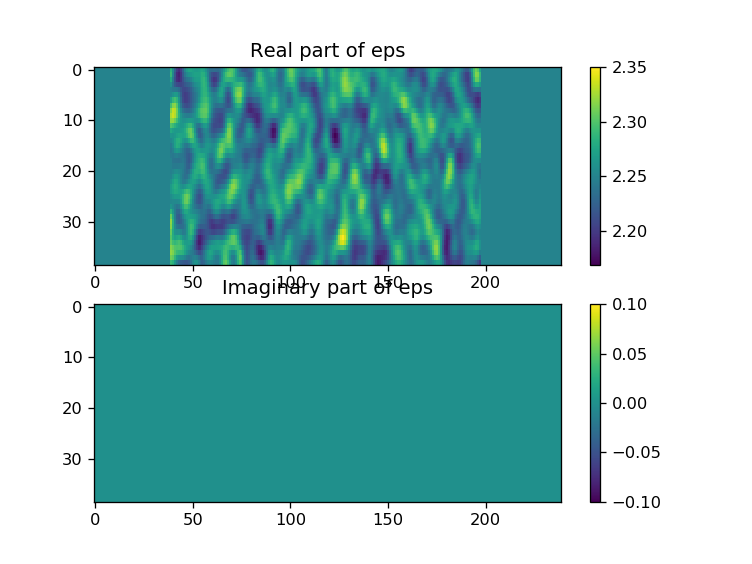

In [22]:
eps_map.generate_random_WG(kLcorr = kLcorr)

eps_map.display()

In [24]:
rgf_solver = Solver()

rgf_solver.set_eps_map(eps_map)

In [25]:
%matplotlib notebook
print(rgf_solver._N_modes)



4


In [26]:
rgf_solver.run()

2020-05-12 18:53:03,536 - pyRGF.core [INFO   ]  Generating mode basis for 4 modes.
2020-05-12 18:53:03,537 - pyRGF.core [INFO   ]  Mode basis generated.
2020-05-12 18:53:03,538 - pyRGF.core [INFO   ]  Starting recursive Green's function iteration.
100%|██████████| 239/239 [00:00<00:00, 4740.25it/s]
2020-05-12 18:53:03,591 - pyRGF.core [INFO   ]  RGF iteration finished in 0.05s.


In [27]:
r1, t1, r2, t2 = rgf_solver.get_matrices()

<IPython.core.display.Javascript object>


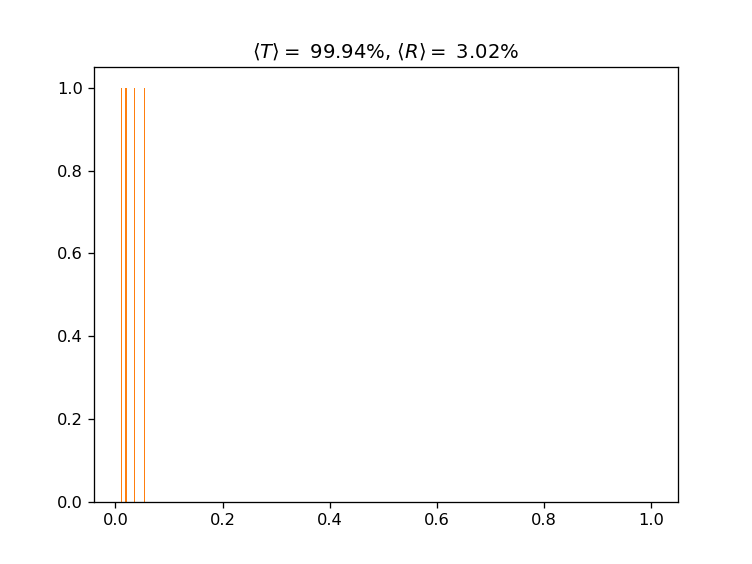

In [28]:
u,s,vh = svd(t1);
u2,s2,vh2 = svd(r1);

plt.figure()

plt.hist(s,20)
plt.hist(s2,20)
plt.title(r"$\left\langle T \right\rangle = $ " + f"{np.mean(s*100):.2f}%, " + \
          r"$\left\langle R \right\rangle = $ " + f"{np.mean(s2*100):.2f}%");

In [31]:
E_in = vh[-1,:].conjugate()
E_out = t1@E_in
Rv = np.linalg.norm(t1@E_in)**2/np.linalg.norm(E_in)**2
Tv = np.linalg.norm(r1@E_in)**2/np.linalg.norm(E_in)**2
print(f"R = {Rv}")
print(f"R = {Tv}")
print(f"R+T = {Rv+Tv}")

R = 0.9969876293731045
R = 0.0030123050644508746
R+T = 0.9999999344375553


In [32]:
E_in = np.zeros(rgf_solver._N_modes, dtype = complex); E_in[0] = 1.
Rv = np.linalg.norm(t1@E_in)**2/np.linalg.norm(E_in)**2
Tv = np.linalg.norm(r1@E_in)**2/np.linalg.norm(E_in)**2
print(f"R = {Rv}")
print(f"R = {Tv}")
print(f"R+T = {Rv+Tv}")
# E_in = np.ones(rgf_solver._N_modes, dtype = complex)
# E_in = vh[-3,:].conjugate()
E_out = t1@E_in

E_internal = rgf_solver.get_internal_field(E_in)

2020-05-12 18:53:04,438 - pyRGF.core [INFO   ]  Excitation from the left side only.


R = 0.9996824257768542
R = 0.000317536231079908
R+T = 0.9999999620079341


<IPython.core.display.Javascript object>


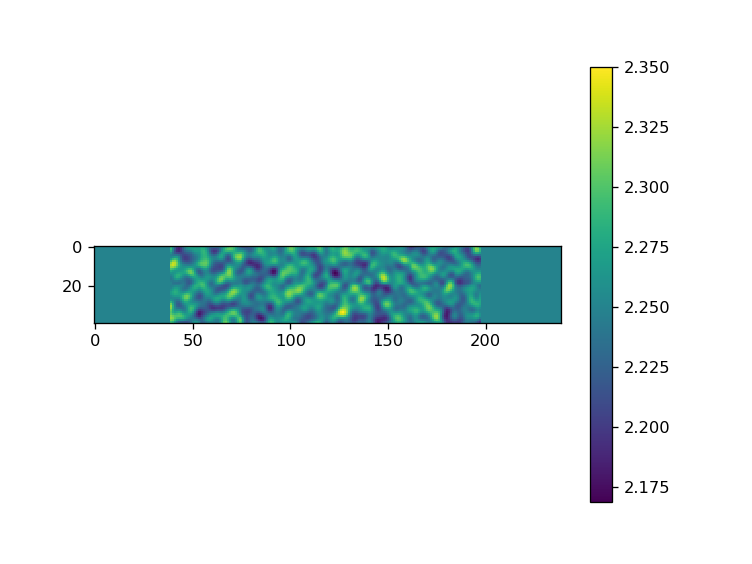

In [33]:
plt.figure()
plt.imshow(np.real(rgf_solver.eps_map.eps))
plt.colorbar()

2020-05-12 19:19:12,123 - pyRGF.core [INFO   ]  Excitation from the left side only.
2020-05-12 19:19:12,181 - pyRGF.core [INFO   ]  Excitation from the right side only.


<IPython.core.display.Javascript object>


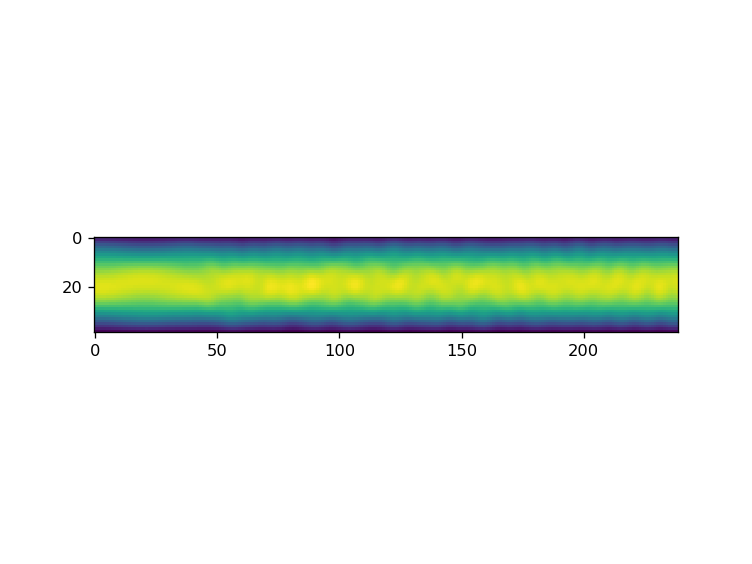

<IPython.core.display.Javascript object>


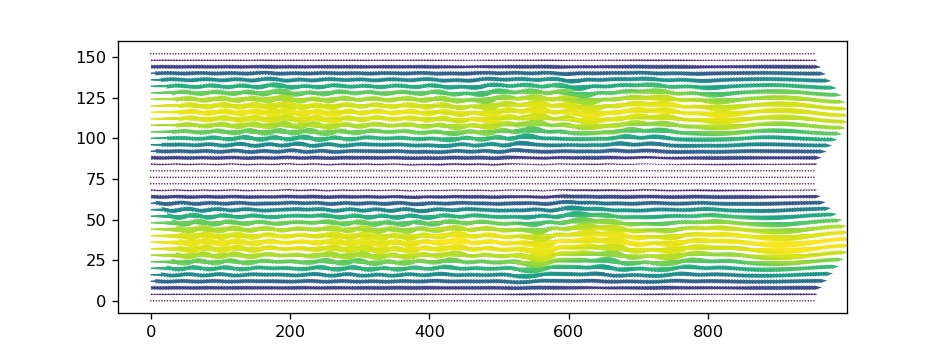

<IPython.core.display.Javascript object>


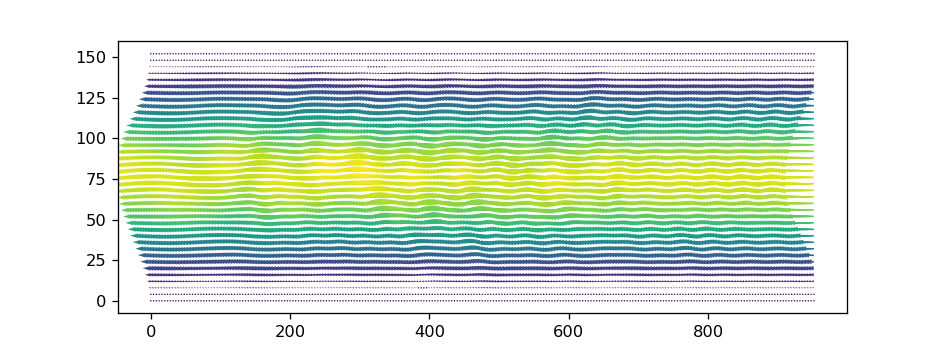

477.6345787924511

In [59]:
E_in_left = np.zeros(rgf_solver._N_modes, dtype = complex); 
E_in_left[1] = 1.
E_internal_left = rgf_solver.get_internal_field(E_in_left = E_in_left)
E_in_right = np.zeros(rgf_solver._N_modes, dtype = complex); 
E_in_right[0] = 1.
E_internal_right = rgf_solver.get_internal_field(E_in_right = E_in_right)

plt.figure()
plt.imshow(np.abs(E_internal))



def get_P_vec(E):

    grad_E = np.gradient(E)
    Py = np.imag(E.conjugate()*grad_E[0])
    Px = np.imag(E.conjugate()*grad_E[1])
    
    return np.stack((Px, Py))
                            


P_vec_left = get_P_vec(E_internal_left)
P_vec_right = get_P_vec(E_internal_right)

plt.figure(figsize = (8,3))
Q = plt.quiver(eps_map.X, 
               eps_map.Y, 
               P_vec_left[0], 
               P_vec_left[1],
               np.hypot(P_vec_left[1],P_vec_left[0]),
               angles = 'xy',
               width=0.0022,
               scale= 1.)

plt.figure(figsize = (8,3))
Q = plt.quiver(eps_map.X, 
               eps_map.Y, 
               P_vec_right[0], 
               P_vec_right[1],
               np.hypot(P_vec_right[1],P_vec_right[0]),
               angles = 'xy',
               width=0.0022,
               scale= 1.)
# plt.quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E',
#                    coordinates='figure')

np.sum(P_vec_left[0]-P_vec_right[0])

<IPython.core.display.Javascript object>


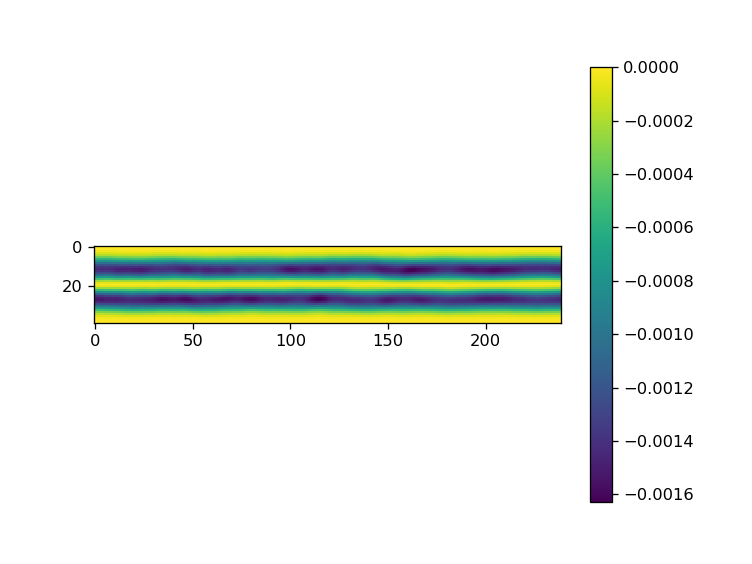

In [68]:
plt.figure()
plt.imshow(P_vec_left[0]*P_vec_right[0]); plt.colorbar()

In [13]:
E_internal.shape

(39, 239)

In [14]:
raise

RuntimeError: No active exception to reraise

2020-05-12 19:10:26,318 - pyRGF.core [INFO   ]  Excitation from the left side only.
2020-05-12 19:10:26,386 - pyRGF.core [INFO   ]  Excitation from the right side only.
2020-05-12 19:10:26,445 - pyRGF.core [INFO   ]  Excitation from the left side only.
2020-05-12 19:10:26,502 - pyRGF.core [INFO   ]  Excitation from the right side only.
2020-05-12 19:10:26,553 - pyRGF.core [INFO   ]  Excitation from the left side only.
2020-05-12 19:10:26,602 - pyRGF.core [INFO   ]  Excitation from the right side only.


0/0 : 237.8580624242495
0/1 : 239.79859754330556


2020-05-12 19:10:26,653 - pyRGF.core [INFO   ]  Excitation from the left side only.
2020-05-12 19:10:26,705 - pyRGF.core [INFO   ]  Excitation from the right side only.
2020-05-12 19:10:26,754 - pyRGF.core [INFO   ]  Excitation from the left side only.
2020-05-12 19:10:26,804 - pyRGF.core [INFO   ]  Excitation from the right side only.


0/2 : 239.08189769098448
0/3 : 241.27960567543195


2020-05-12 19:10:26,854 - pyRGF.core [INFO   ]  Excitation from the left side only.
2020-05-12 19:10:26,905 - pyRGF.core [INFO   ]  Excitation from the right side only.
2020-05-12 19:10:26,954 - pyRGF.core [INFO   ]  Excitation from the left side only.
2020-05-12 19:10:27,011 - pyRGF.core [INFO   ]  Excitation from the right side only.


1/0 : -1.1295126600699845
1/1 : 0.8110224589860469


2020-05-12 19:10:27,063 - pyRGF.core [INFO   ]  Excitation from the left side only.
2020-05-12 19:10:27,110 - pyRGF.core [INFO   ]  Excitation from the right side only.
2020-05-12 19:10:27,175 - pyRGF.core [INFO   ]  Excitation from the left side only.
2020-05-12 19:10:27,238 - pyRGF.core [INFO   ]  Excitation from the right side only.


1/2 : 0.09432260666496983
1/3 : 2.2920305911124244


2020-05-12 19:10:27,304 - pyRGF.core [INFO   ]  Excitation from the left side only.
2020-05-12 19:10:27,379 - pyRGF.core [INFO   ]  Excitation from the right side only.
2020-05-12 19:10:27,443 - pyRGF.core [INFO   ]  Excitation from the left side only.
2020-05-12 19:10:27,497 - pyRGF.core [INFO   ]  Excitation from the right side only.


2/0 : -1.142654698967501
2/1 : 0.7978804200885299


2020-05-12 19:10:27,560 - pyRGF.core [INFO   ]  Excitation from the left side only.
2020-05-12 19:10:27,621 - pyRGF.core [INFO   ]  Excitation from the right side only.
2020-05-12 19:10:27,688 - pyRGF.core [INFO   ]  Excitation from the left side only.
2020-05-12 19:10:27,751 - pyRGF.core [INFO   ]  Excitation from the right side only.


2/2 : 0.08118056776745261
2/3 : 2.2788885522149083


2020-05-12 19:10:27,816 - pyRGF.core [INFO   ]  Excitation from the left side only.
2020-05-12 19:10:27,879 - pyRGF.core [INFO   ]  Excitation from the right side only.
2020-05-12 19:10:27,938 - pyRGF.core [INFO   ]  Excitation from the left side only.
2020-05-12 19:10:27,988 - pyRGF.core [INFO   ]  Excitation from the right side only.


3/0 : -0.6024670175309786
3/1 : 1.3380681015250508


2020-05-12 19:10:28,040 - pyRGF.core [INFO   ]  Excitation from the left side only.
2020-05-12 19:10:28,093 - pyRGF.core [INFO   ]  Excitation from the right side only.


3/2 : 0.6213682492039727
3/3 : 2.8190762336514275


<IPython.core.display.Javascript object>


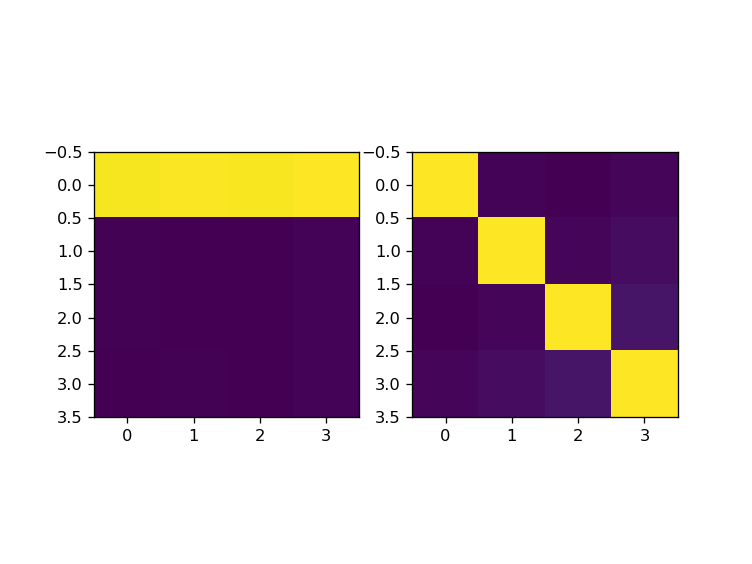

In [49]:
# for i_mode in range(rgf_solver._N_modes):
from itertools import product

T = np.zeros([rgf_solver._N_modes]*2)
for i_mode, j_mode in product(range(rgf_solver._N_modes),range(rgf_solver._N_modes)):
    E_in_left = np.zeros(rgf_solver._N_modes, dtype = complex); 
    E_in_left[i_mode] = 1.
    E_internal_left = rgf_solver.get_internal_field(E_in_left = E_in_left)
    P_left = get_P_vec(E_internal_left)
    
    E_in_right = np.zeros(rgf_solver._N_modes, dtype = complex); 
    E_in_right[j_mode] = 1.
    E_internal_right = rgf_solver.get_internal_field(E_in_right = E_in_right)
    P_right = get_P_vec(E_internal_right)
    
    
#     print(i_mode,j_mode)
    T[i_mode,j_mode] = np.sum(P_left-P_right)
    print(f'{i_mode}/{j_mode} : {T[i_mode,j_mode]}')
            #np.sum(P_left*P_right) #\
#                        / np.sqrt(np.sum(np.abs(E_internal_left)) \
#                                  * np.sum(np.abs(E_internal_right)))
    
plt.figure()
plt.subplot(121)
plt.imshow(np.abs(T))
plt.subplot(122)
plt.imshow(np.abs(rgf_solver.t2))

In [ ]:
plt.figure()
plt.imshow(np.abs(E_internal_right))

In [ ]:
plt.figure()
plt.subplot(121)
plt.imshow(np.abs(T))
plt.subplot(122)
plt.imshow(np.abs(rgf_solver.t2))

In [ ]:

plt.figure()
plt.imshow((np.abs(E_internal)**2))

I_x = np.sum(np.abs(E_internal)**2, axis = 0)

plt.figure()
plt.plot(I_x)



# plt.figure()
# plt.subplot(121)
# plt.plot(np.abs(rgf_solver._psi.transpose().conjugate()@E_out))
# plt.subplot(122)
# plt.plot(np.abs(E_internal[:,-1]))

In [ ]:
plt.figure()
# plt.subplot(121)
plt.plot(np.abs(rgf_solver._psi.transpose().conjugate()@rgf_solver.speed_norm@(t1@E_in)))
# plt.subplot(122)
plt.plot(np.abs(E_internal[:,-1]), 'r')
plt.plot(np.abs(E_internal[:,-2]), 'g')

In [ ]:
plt.figure()
# plt.subplot(121)
plt.plot(np.abs(rgf_solver._psi.transpose().conjugate()@rgf_solver.speed_norm@(E_in+r1@E_in)))
# plt.subplot(122)
plt.plot(np.abs(E_internal[:,0]), 'r')
plt.plot(np.abs(E_internal[:,1]), 'g')

In [ ]:
vec = rgf_solver.eps_map.eps.ravel()
rgf_solver._Ny
np.max(vec)